In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
path_to_data = '/home/dnash/SEAK_clim_data/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [13]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
start_date = '1980-01-01 00'
end_date = '2019-12-31 23'

# open precipitation data
fname = path_to_out + 'SEAK_precip_max_{0}_{1}.csv'.format(option, temporal_res)
df_prec = pd.read_csv(fname)
# df_prec = df_prec.replace(0, np.NaN) # replace any instance of zero with nan to ignore dates with no precipitation

# open IVT data
df_lst = []
for i, community in enumerate(community_lst):
    fname = path_to_out + 'IVT_ERA5_{0}.csv'.format(community)
    ivt_df = pd.read_csv(fname)
    
    ## calculate IVT direction
    uvec = units.Quantity(ivt_df['uIVT'].values, "m/s")
    vvec = units.Quantity(ivt_df['vIVT'].values, "m/s")
    ivtdir = mpcalc.wind_direction(uvec, vvec)
    ivt_df['ivtdir'] = ivtdir
    ivt_df = ivt_df.drop(['Unnamed: 0'], axis=1) # drop unnecessary vars
    
    if temporal_res == 'hourly':
        ivt_df = ivt_df
    elif temporal_res == 'daily':
        # ivt_df.index = ivt_df['time']
        ivt_df = ivt_df.set_index(pd.to_datetime(ivt_df['time'])) # reset the index as "date" # fix to work for this notebook
        ivt_df = ivt_df.resample('1D').mean()
        
    ## slice to start_date, end_date
    idx = (ivt_df.index > start_date) & (ivt_df.index <= end_date)
    ivt_df = ivt_df.loc[idx]
    
#     ## append AR data
#     fname = path_to_out + 'SEAK_ardates_{0}.csv'.format(temporal_res)
#     ar_df = pd.read_csv(fname) # read in AR dates
#     # append AR dates to current df
#     ivt_df['AR'] = ar_df.AR
    
#     ## append impact data
#     fname = path_to_out + 'SEAK_impactdates_{0}.csv'.format(temporal_res)
#     impact_df = pd.read_csv(fname) # read in impact dates
#     # append impact dates to current df
#     ivt_df['impact'] = impact_df.IMPACT
    
#     # ## append community precipitation data
#     ivt_df['prec'] = df_prec[community]
    df_lst.append(ivt_df)
    
df_lst[0]


/tmp/ipykernel_10596/3027745379.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ivt_df = ivt_df.resample('1D').mean()
/tmp/ipykernel_10596/3027745379.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ivt_df = ivt_df.resample('1D').mean()
/tmp/ipykernel_10596/3027745379.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ivt_df = ivt_df.resample('1D').mean()
/tmp/ipykernel_10596/3027745379.py:32: FutureWarning

,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir
time,,,,,,,
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2019-12-27,91.43,58.00,-135.50,61.35,65.65,7.73,225.77
2019-12-28,221.96,58.00,-135.50,39.06,209.42,12.02,199.91
2019-12-29,89.09,58.00,-135.50,13.36,85.46,9.03,188.47


In [10]:
# number of days per year with precipitation > 0.1
for i, df in enumerate(df_lst):  
    total_count = df.shape[0]
    calm_count = df.query("prec < 0.1").shape[0]
    print('Of {} total observations, {} have less than 2 mm of precipitation.'.format(total_count, calm_count))
    x = (total_count - calm_count) / 40.
    print('On average, there are', x, 'days per year with precipitation greater than 0.1 mm per day')

Of 14975 total observations, 0 have less than 2 mm of precipitation.
On average, there are 374.375 days per year with precipitation greater than 0.1 mm per day
Of 14975 total observations, 0 have less than 2 mm of precipitation.
On average, there are 374.375 days per year with precipitation greater than 0.1 mm per day
Of 14975 total observations, 0 have less than 2 mm of precipitation.
On average, there are 374.375 days per year with precipitation greater than 0.1 mm per day
Of 14975 total observations, 0 have less than 2 mm of precipitation.
On average, there are 374.375 days per year with precipitation greater than 0.1 mm per day
Of 14975 total observations, 0 have less than 2 mm of precipitation.
On average, there are 374.375 days per year with precipitation greater than 0.1 mm per day
Of 14975 total observations, 0 have less than 2 mm of precipitation.
On average, there are 374.375 days per year with precipitation greater than 0.1 mm per day


## Get some basic stats

In [16]:
perc = [0., 0.05, 0.25, 0.5, 0.75, .95]
perc_lbl = ['0%', '5%', '25%', '50%', '75%', '95%']
final_thres = []
for i, df in enumerate(df_lst):
    test = []
    for j, (thres, lbl) in enumerate(zip(perc, perc_lbl)):
        test.append(df['prec'].describe(percentiles=[thres]).loc[[lbl]].values)
    final_thres.append(test)
final_thres

# prec_bins = [0, 2, 5, 10, 15, 20, 25, 30, 35, np.inf]

[[array([0.00012207]),
  array([0.046875]),
  array([0.33203125]),
  array([0.91015625]),
  array([1.7890625]),
  array([3.75])],
 [array([1.5258789e-05]),
  array([0.00927734]),
  array([0.06347656]),
  array([0.18554688]),
  array([0.41601562]),
  array([1.2556152])],
 [array([3.0517578e-05]),
  array([0.02929688]),
  array([0.17773438]),
  array([0.46875]),
  array([0.90234375]),
  array([2.2714844])],
 [array([0.00024414]),
  array([0.0703125]),
  array([0.47265625]),
  array([1.2109375]),
  array([2.4296875]),
  array([5.1875])],
 [array([6.1035156e-05]),
  array([0.02539062]),
  array([0.19921875]),
  array([0.5576172]),
  array([1.2109375]),
  array([2.8515625])],
 [array([6.1035156e-05]),
  array([0.03515625]),
  array([0.27734375]),
  array([0.83203125]),
  array([1.6914062]),
  array([3.75])]]

In [ ]:
# 95th percentile threshold for precipitation and IVT for ALL days
prec_thres = []
ivt_thres = []
for i, df in enumerate(df_lst):
    prec_thres.append(df['prec'].describe(percentiles=[.95]))
    ivt_thres.append(df['ivt'].describe(percentiles=[.95]))
    
    data['IVT'].describe(percentiles=[.95]).loc['95%']

### Plot IVT/Precip Scatter and IVT direction and precipitation in windrose
Use https://gist.github.com/phobson/41b41bdd157a2bcf6e14 as an example

In [22]:
## Define a function that gives nice labels for precipitation ranges

def range_labels(bins, units):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('clear'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))

    return list(labels)

## Define a function to convert centered angles to left-edge radians
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

## define wind rose function
def wind_rose(ax, rosedata, wind_dirs, legend_req, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])
    else:
        palette = sns.color_palette(palette, n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    if legend_req == True:
        leg = ax.legend(loc=(0.75, 0.95), ncol=1)
    
    return ax

def calc_rose(df, prec_bins, prec_labels, dir_bins, dir_labels):
    '''
    ### Determine the relative percentage of observation in each speed and direction bin
    Here's how we do it:

    - assign a precipitation bin for each row with pandas.cut
    - assign a direction bin for each row (again, pandas.cut)
    - unify the 360° and 0° bins under the 0° label
    - group the data simultaneously on both precipitation and direction bins
    - compute the size of each group
    - unstack (pivot) the speed bins into columns
    - fill missing values with 0
    - assign a "calm" column to be the total number of calm observations evenly distributed across all directions
    - sort the columns -- they are a catgerical index, so "calm" will be first (this is awesome!)
    - convert all of the counts to percentages of the total number of observations
    '''
    total_count = df.shape[0]
    calm_count = df.query("prec < 0.1").shape[0]
    print('Of {} total observations, {} have less than 2 mm of precipitation.'.format(total_count, calm_count))
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=prec_labels, right=True))
          .assign(ivtdir_bins=lambda df: pd.cut(df['ivtdir'], bins=dir_bins, labels=dir_labels, right=False))
          .replace({'ivtdir_bins': {360: 0}})
          .groupby(by=['prec_bins', 'ivtdir_bins'])
          .size()
          .unstack(level='prec_bins')
          .fillna(0)
          .assign(clear=lambda df: calm_count / df.shape[0])
          .sort_index(axis=1)
          .applymap(lambda x: x / total_count * 100))
        
    return df

IVT thres 501.6054054629533 Prec thres 3.75
IVT thres 340.00749638850584 Prec thres 1.2556152
IVT thres 326.0363124545043 Prec thres 2.2714844
IVT thres 469.7583865434144 Prec thres 5.1875
IVT thres 616.1114076074803 Prec thres 2.8515625
IVT thres 579.1848544616493 Prec thres 3.75


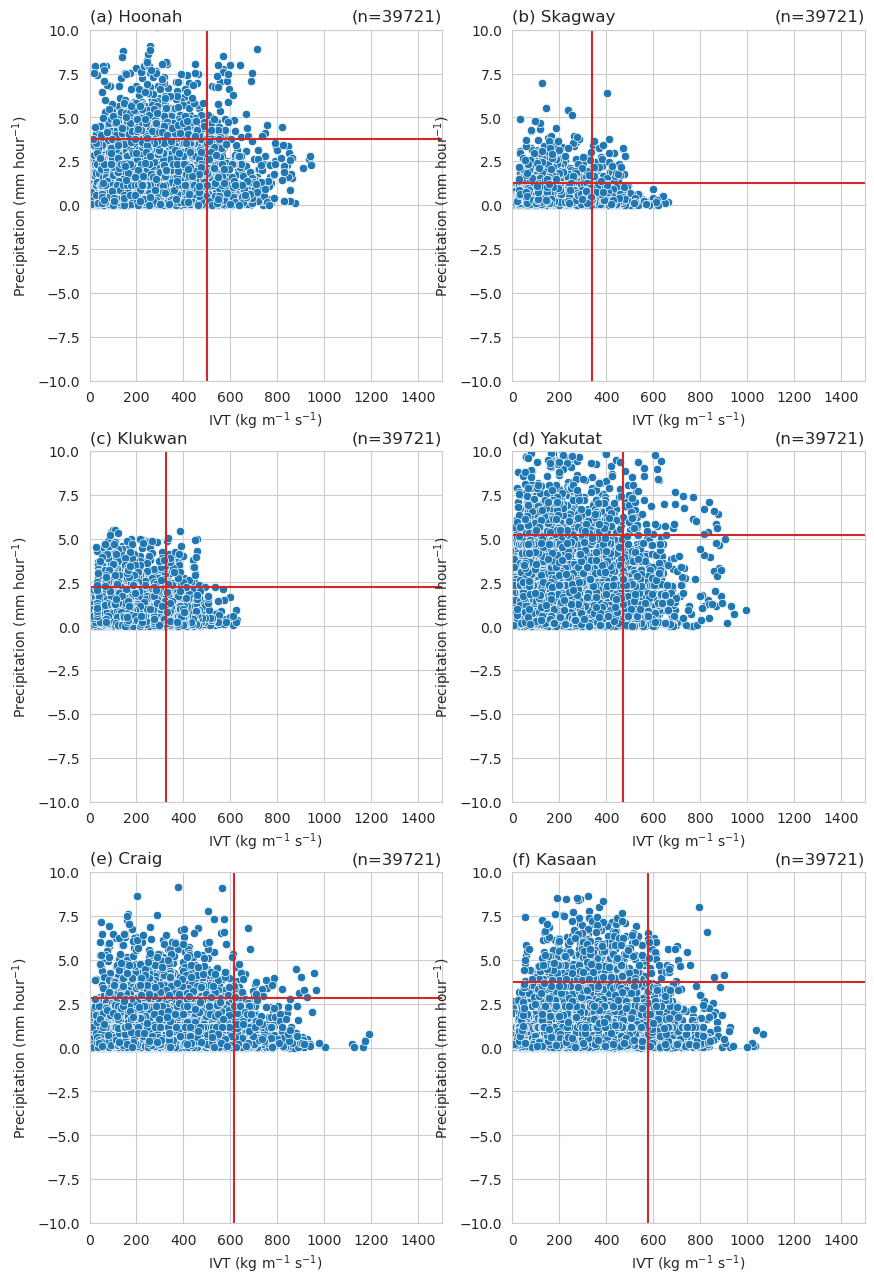

../figs/IVT-prec_scatter.png


In [7]:
# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

fname = path_to_figs + 'IVT-prec_scatter'
fmt = 'png'
nrows = 3
ncols = 2
nplots=nrows*ncols

fig = plt.figure(figsize=(10,15.5))

sns.set_style("whitegrid")

for i, df in enumerate(df_lst):
    ax = fig.add_subplot(nrows, ncols, i+1)
    
    # plot AR cases
    data = df.loc[(df.AR == 1)]
    n = len(data)

    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c='tab:blue')
    
    ## get 95th percentile of ivt and precip
    ivt_thres = data['IVT'].describe(percentiles=[.95]).loc['95%']
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%']
    print('IVT thres', ivt_thres, 'Prec thres', prec_thres)
    
    plt.axhline(y=prec_thres, color='tab:red', linestyle='-')
    plt.axvline(x=ivt_thres, color='tab:red', linestyle='-') 
    
    ax.set_ylabel('Precipitation (mm hour$^{-1}$)')
    ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    ax.set_ylim(-10, 10)
    ax.set_xlim(0, 1500)
    ax.set_title('({0}) {1}'.format(letter_lst[i], community_lst[i]), loc='left')
    ax.set_title('(n={0})'.format(n), loc='right')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)

Of 39721 total observations, 1021 have less than 2 mm of precipitation.


/tmp/ipykernel_109761/3340451842.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 39721 total observations, 2803 have less than 2 mm of precipitation.


/tmp/ipykernel_109761/3340451842.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 39721 total observations, 1570 have less than 2 mm of precipitation.


/tmp/ipykernel_109761/3340451842.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 39721 total observations, 721 have less than 2 mm of precipitation.


/tmp/ipykernel_109761/3340451842.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 39721 total observations, 1542 have less than 2 mm of precipitation.


/tmp/ipykernel_109761/3340451842.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


Of 39721 total observations, 1112 have less than 2 mm of precipitation.


/tmp/ipykernel_109761/3340451842.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


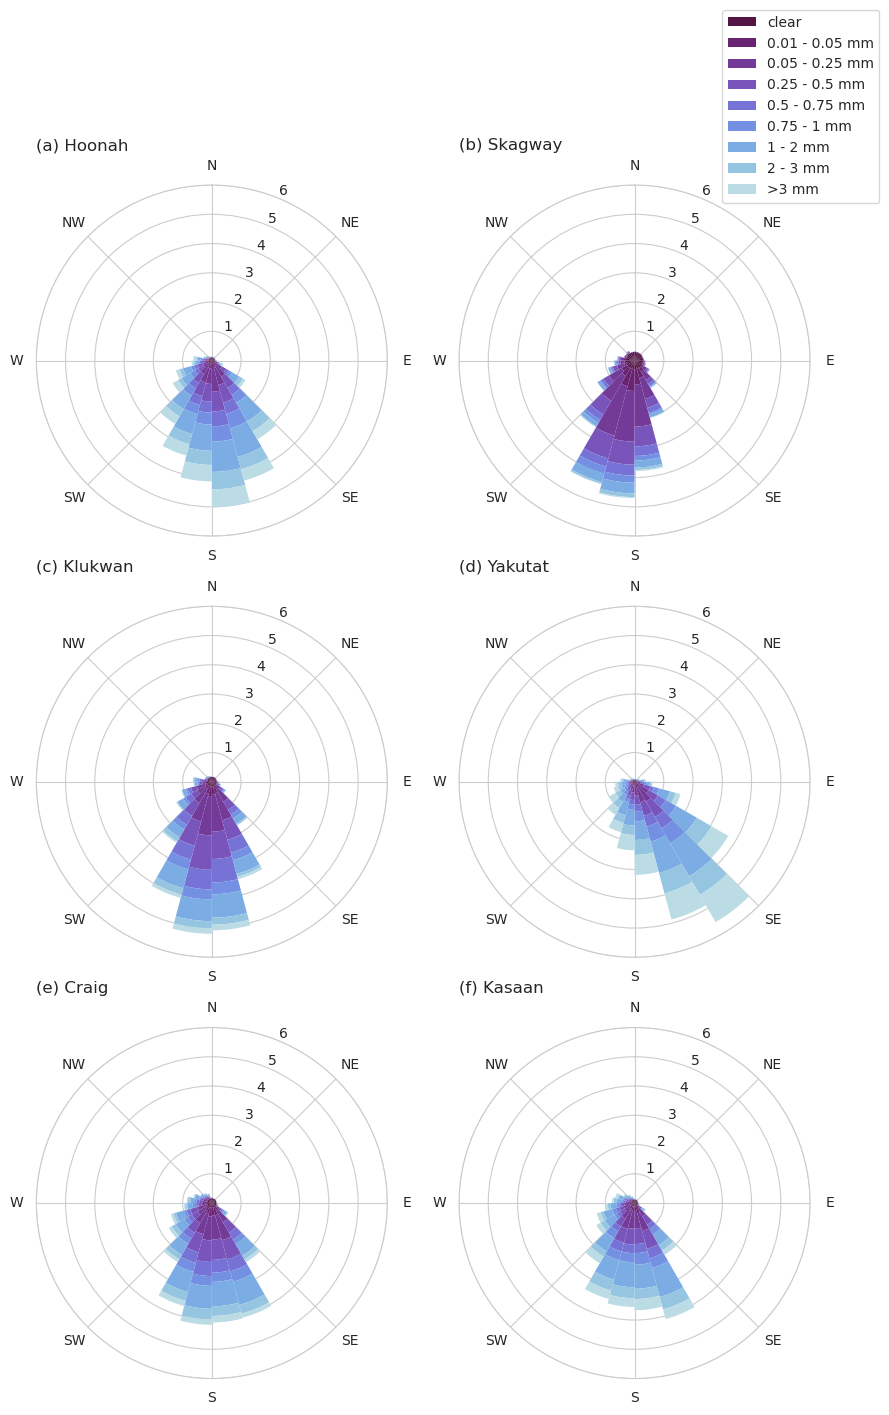

../figs/windrose.png


In [25]:
## update plot so that it is 3 columns (ar type) by 1 rows (location of precip)
fname = path_to_figs + 'windrose'
fmt = 'png'
nrows = 3
ncols = 2
nplots=nrows*ncols

fig = plt.figure(figsize=(10,15.5))

sns.set_style("whitegrid")

#####################
### PLOT WINDROSE ###
#####################

## Define our bins and labels for speed and wind
prec_bins = [0, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 2, 3, np.inf]
prec_labels = range_labels(prec_bins, units='mm')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

## use wind rose function
directions = np.arange(0, 360, 15)
legend_req = [False, True] + [False]*4
rad_ticks = [1, 2, 3, 4, 5, 6]
## loop through each AR type to plot wind rose
for i, df in enumerate(df_lst):
    ax = fig.add_subplot(nrows, ncols, i+1, projection='polar')
    
    # plot AR cases
    data = df.loc[(df.AR == 1)]
    rose = calc_rose(data, prec_bins, prec_labels, dir_bins, dir_labels)
    
    ax = wind_rose(ax, rose, directions, legend_req[i], palette="cmo.dense_r")

    ax.set_rticks(rad_ticks)  # Less radial ticks
    ax.set_title('({0}) {1}'.format(letter_lst[i], community_lst[i]), loc='left')

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)